<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/05_transfer_learning_in_tensorflow-part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow 2 : Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : fine-tuning

In [22]:
# Check if we're using a GPU
!nvidia-smi

Sun Jul 18 02:37:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    36W /  70W |   2736MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download some of the functions we've used previously here : https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-07-18 02:37:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-18 02:37:59 (90.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [24]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note** : If you're running this notebook in Google Colab, when it times out Colab will delete `helper functions`, so you'll have to re-download it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pre-trained models within `tf.keras.applications`  (recognizing images of food)
 link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [25]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-07-18 02:38:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.208, 142.251.33.208, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   267MB/s    in 0.6s    

2021-07-18 02:38:00 (267 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [26]:
# Check out how many image and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [27]:
# Create training and test directory paths
train_dir ="10_food_classes_10_percent/train"
test_dir ="10_food_classes_10_percent/test"

In [28]:
import tensorflow as tf

In [29]:
# Preprocess image dataset in a directory https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

IMG_SIZE=(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [31]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [32]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1) :
  print(images, labels)

tf.Tensor(
[[[[219.57143   226.57143   232.57143  ]
   [225.83163   233.83163   236.83163  ]
   [227.        235.        238.       ]
   ...
   [100.647995  110.4235    107.5714   ]
   [101.97449   112.97449   106.97449  ]
   [ 99.28568   110.99996   102.64282  ]]

  [[218.92857   225.92857   231.92857  ]
   [226.78572   234.78572   237.78572  ]
   [228.34183   236.34183   239.34183  ]
   ...
   [ 99.943855  112.15814   108.48463  ]
   [ 96.719376  111.862236  104.7908   ]
   [ 95.38262   111.668335  101.73976  ]]

  [[217.35715   224.35715   230.35715  ]
   [225.94388   233.94388   236.94388  ]
   [229.38264   237.38264   240.38264  ]
   ...
   [ 94.07139   110.306114  103.11732  ]
   [ 90.85714   109.42857   103.       ]
   [ 91.49493   110.70921   104.06635  ]]

  ...

  [[ 53.65819    65.65819    65.65819  ]
   [ 51.403038   62.97445    61.188744 ]
   [ 53.617317   65.23466    60.806084 ]
   ...
   [ 53.811172   49.163303   45.42345  ]
   [ 50.85721    49.142975   41.714386 ]
   [ 

## Model 0 : Building a transfer learning feature extraction model using the Keras Functional API
The sequential API is straight-forward, it runs our layers in sequential order.
But the functional API gives ur more flexibility with our models -https://www.tensorflow.org/guide/keras/functional

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model(so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3) , name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs(Not required for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model : {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D : {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks =[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model : (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D : (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210718-023641
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 317ms/step - loss: 1.8681 - accuracy: 0.4387 - val_loss: 1.3341 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 5s 197ms/step - loss: 1.1316 - accuracy: 0.7613 - val_loss: 0.9156 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 5s 196ms/step - loss: 0.8274 - accuracy: 0.8320 - val_loss: 0.7711 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - 5s 205ms/step - loss: 0.6786 - accuracy: 0.8440 - val_loss: 0.6546 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 5s 198ms/step - loss: 0.5911 - accuracy: 0.8667 - val_loss: 0.6027 - val_accuracy: 0.8405


In [13]:
# Evaulate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 109ms/step - loss: 0.6068 - accuracy: 0.8408


[0.606772243976593, 0.8407999873161316]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers) :
  print (layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


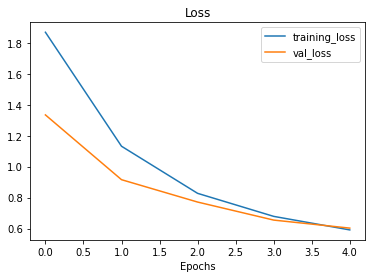

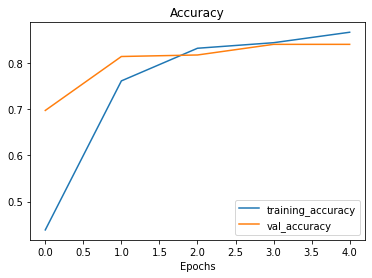

In [17]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a featured vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after out model goes through `base model` of shape (None, 7, 7, 1280)

But when it passes through GlobalAveragePooling2D it turns to (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.



In [18]:
# Define the input shape
input_shape =  (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : \n {input_tensor} \n")

# pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D global average pooled random tensor :\n {global_average_pooled_tensor} \n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooling 2D tensor : {global_average_pooled_tensor.shape}")

Random input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor :
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooling 2D tensor : (1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> **Practice** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

**Note** : One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns our of for our own specific problem.

In [20]:
# Let's try the same with GlobalMaxPool2D

input_shape=(1, 4, 4, 3)

# Create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : \n {input_tensor} \n")

# Pass the random tensor to GlobalMaxPool2D
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Global Max Pool tensor : \n {global_max_pool_tensor} \n")

# Compare the shape
print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of GlobalMaxPool tensor : {global_max_pool_tensor.shape}")


Random input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

Global Max Pool tensor : 
 [[0.9058464 1.1603122 1.6994323]] 

Shape of input tensor : (1, 4, 4, 3)
Shape of GlobalMaxPool tensor : (1, 3)


In [21]:
# Let's replicate the GlobalMaxPool2D layer
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

# Running a series of transfer learning experiments
We've seen the incredible results transfer learning can get with only 10% od the training data , but how does it go with 1% of the training data... how about we set up a bunch of experiemnts to find out:


1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 1% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of training data wiht data augmentation

> **Note** : throughtout all experiments the same test dataset will be used to evaluated our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [33]:
# Download and unzip data - preprocessed from Food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")


--2021-07-18 02:38:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 172.217.12.240, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   153MB/s    in 0.8s    

2021-07-18 02:38:04 (153 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [34]:
# Create training and test dir

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [35]:
# How many images we are working with 
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [36]:
# Setup Data Loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation right into model 
To add data augmentation right into our models, we can use layers inside :
 * `tf.keras.layers.experimental.preprocessing()`


 We can see the benefits of using preprocessing layers for data augmentation 
 https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers


Off the top of heads, after reading the docs, the benefits of data augmentation inside the model are :
* Preprocessing of images (augmenting them) happens on the GPU(much faster) rather than CPU.
*  Image data augmentation happens only during training, so we can still export our whole model and use it elsewhere.

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zooms etc
data_augmentation = keras.Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(0.2),
            preprocessing.RandomZoom(0.2),
            preprocessing.RandomHeight(0.2),
            preprocessing.RandomWidth(0.2),
            #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's have rescaling built-in
                                                                                     
], name="data_augmentation")

### Visualize our data augmentation layer(and see what happens to our data)

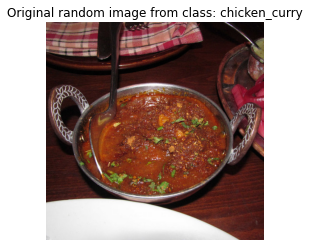

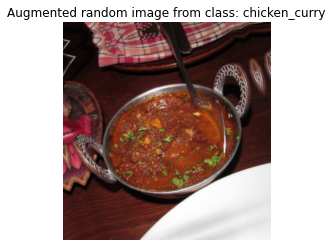

In [67]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model_1 : Feature Extraction transfer learning on 1% of the data with data augmentation


In [28]:
# Set up input shape and base model, freezing the base model layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the ouput
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])





Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210717-173922
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 11s 3s/step - loss: 2.4347 - accuracy: 0.0429 - val_loss: 2.2623 - val_accuracy: 0.1151
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1821 - accuracy: 0.1714 - val_loss: 2.1330 - val_accuracy: 0.2418
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9757 - accuracy: 0.3571 - val_loss: 2.0240 - val_accuracy: 0.3092
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8080 - accuracy: 0.5286 - val_loss: 1.9289 - val_accuracy: 0.3783
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6546 - accuracy: 0.6857 - val_loss: 1.8335 - val_accuracy: 0.4441


In [29]:
# Check model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [30]:
# Evaluate on full test data set
results_1_percent_data_aug= model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 9s 109ms/step - loss: 1.8229 - accuracy: 0.4544


[1.8229279518127441, 0.4544000029563904]

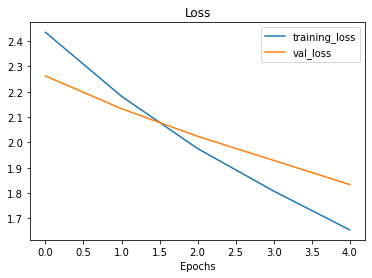

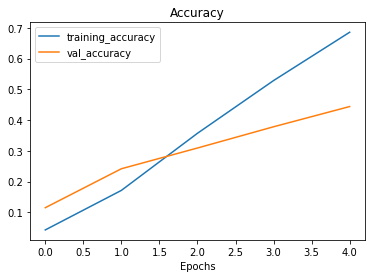

In [31]:
# How do model with 1% of the data augmentation loss curves look
plot_loss_curves(history_1_percent)

## Model 2 : feature extraction transfer learning with 10% of data and data augmentation

In [38]:
# Get 10% of data...(uncomment if you dont have it)
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [39]:
# How many images are in our directories
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [40]:
# Set data inputs
import tensorflow as tf

IMG_SIZE=(224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [41]:
# Create model_2 with data augmentation built in 
from tensorflow.keras  import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomRotation(0.2),
        # preprocessing.Rescaling(1./255)  #For model such as ResNet50V2, you need to rescale. Efficientnet has rescale built-in                    
], name="data_augmentation")


# Setup input shape to our model
input_shape=(224, 224, 3)

# Create  a frozen base model(also called the backbone)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the inputs and outputs(including the layers in between)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs) # augment our training images(augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass the augmented images to base model but keep  it in inference mode, this also insures batchnorm layers don't get updated - https://keras.io/guides/transfer_learning/#build-a-model
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)

#Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])




In [42]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a Model checkpoint call back

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

The ModelCheckpoint callback intermediately saves our model(the full model or just weights) during training.This is useful so we can come and start where we left off.

In [43]:
# Set checkpoint path
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves our model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         weights_only=True,
                                                         save_best_only=True , # you can set to false if save weights for all epochs
                                                         save_freq="epoch", # Save eveery epoch
                                                         verbose=1) 

### Fit model2 passing in the ModelCheckpoint callback

In [44]:
# Fit the model saving checkpoints every epoch
initial_epochs=5
history_10_percent_data_aug = model_2.fit(train_data_10_percent, 
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210718-023808


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 21s 637ms/step - loss: 1.9755 - accuracy: 0.3600 - val_loss: 1.4645 - val_accuracy: 0.6645

Epoch 00001: val_loss improved from inf to 1.46453, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 2/5
24/24 [==============================] - 11s 443ms/step - loss: 1.3287 - accuracy: 0.6747 - val_loss: 1.0417 - val_accuracy: 0.7401

Epoch 00002: val_loss improved from 1.46453 to 1.04170, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 3/5
24/24 [==============================] - 10s 415ms/step - loss: 1.0638 - accuracy: 0.7373 - val_loss: 0.8591 - val_accuracy: 0.7862

Epoch 00003: val_loss improved from 1.04170 to 0.85911, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 4/5
24/24 [==============================] - 10s 415ms/step - loss: 0.8945 - accuracy: 0.7773 - val_loss: 0.7490 - val_accuracy: 0.8109

Epoch 00004: val_loss improved from 0.85911 to 0.74899, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 5/5
24/24 [==============================] - 9s 379ms/step - loss: 0.8009 - accuracy: 0.7947 - val_loss: 0.6877 - val_accuracy: 0.8141

Epoch 00005: val_loss improved from 0.74899 to 0.68769, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets


In [45]:
# What were model_0 results?
model_0.evaluate(test_data)


79/79 [==============================] - 9s 106ms/step - loss: 0.6068 - accuracy: 0.8408


[0.6067721843719482, 0.8407999873161316]

In [46]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.7026 - accuracy: 0.8112


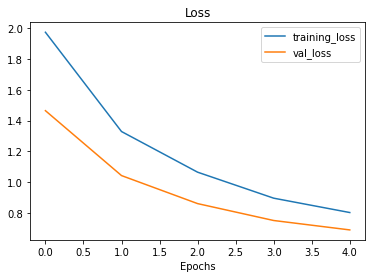

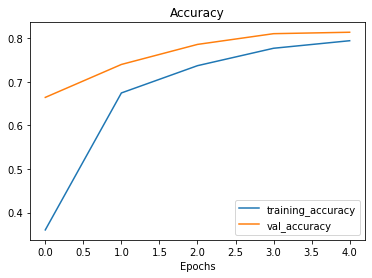

In [47]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

## Loading in checkpointed weights
Loading in checkpointed weight returns a model to a specific checkpoint.



In [48]:
# Load im saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [49]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.7026 - accuracy: 0.8112


In [50]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug ==  loaded_weights_model_results

False

In [51]:
results_10_percent_data_aug

[0.7026161551475525, 0.8112000226974487]

In [52]:
loaded_weights_model_results

[0.702616274356842, 0.8112000226974487]

In [53]:
# Check to see if loaded model results are very close to our previous non-loaded mdoel results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [54]:
# Check the difference between 2 results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Model 3 : Fine-tuning an existing model on 10% of the data

> **Note** : Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [55]:
# Layers in loaed model
model_2.layers

In [56]:
# Are these layers trainable ?
for layer in model_2.layers :
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe9b8e33150> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe9b8df9210> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7fe9b89ff710> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe9b8d08790> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fe9b894ef10> True


In [57]:
# What layers are in our base_model(EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers) :
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [58]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [59]:
 # To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable=True
 base_model.trainable = True

 # Freeze all layers except for last 10
 for layer in base_model.layers[:-10] :
   layer.trainable=False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning, you typically want to lower the learning rate by 10x
                metrics=["accuracy"])


> **Note** : When using fine-tuning it's best practice to lower your learning rate by some amount.
How much? It's a hyperparamter you can tune. But as a good rule of thumb is atleast 10x (though differnt sources will claim other values).

A good resource for information on this is the ULMFiT paper : https://arxiv.org/abs/1801.06146

In [60]:
# Check which layers are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [61]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [62]:
# Fine tune for another 5 epochs
fine_tune_epochs=initial_epochs + 5

# Refit the model(same as model_2 except with more trainable layers)
history_fine_10_percent_data = model_2.fit(train_data_10_percent,
                                           epochs=fine_tune_epochs,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch,
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="10_percent_fine_tune_last_10")]
                                           )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210718-024255
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 21s 618ms/step - loss: 0.6779 - accuracy: 0.8067 - val_loss: 0.5726 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 10s 407ms/step - loss: 0.5501 - accuracy: 0.8453 - val_loss: 0.5221 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 10s 381ms/step - loss: 0.5168 - accuracy: 0.8320 - val_loss: 0.5227 - val_accuracy: 0.8207
Epoch 8/10
24/24 [==============================] - 8s 322ms/step - loss: 0.4605 - accuracy: 0.8613 - val_loss: 0.4912 - val_accuracy: 0.8322
Epoch 9/10
24/24 [==============================] - 9s 374ms/step - loss: 0.4113 - accuracy: 0.8853 - val_loss: 0.4812 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 8s 320ms/step - loss: 0.3764 - accuracy: 0.8920 - val_loss: 0.4659 - val_accuracy: 0.8454


In [63]:
# Evaluate the fine-tuned model(model_3 which actually model_2 fine-tunes for anohter 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.5000 - accuracy: 0.8340


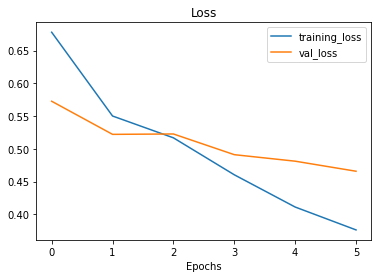

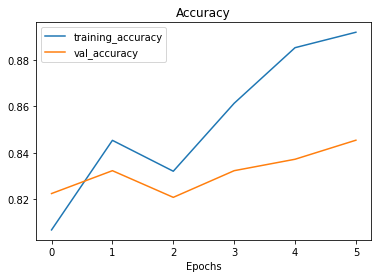

In [64]:
plot_loss_curves(history_fine_10_percent_data)

> The `plot_loss_curves` function works great with models which have only fit once, however, we want something to compare one series of running `fit()` with another(e.g. before and after fine-tuning).

In [65]:
# Let's create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5) :
  """
    Compare 2 TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training And Validation Accuracy")

   # Make plots for loss 
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training And Validation Loss")




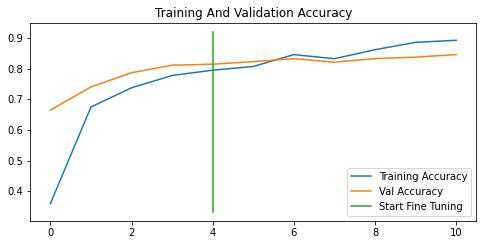

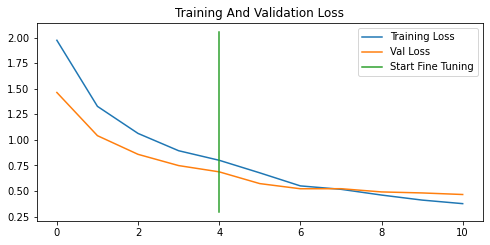

In [68]:
compare_history(original_history=history_10_percent_data_aug, 
                new_history=history_fine_10_percent_data,
                initial_epochs=5
                )

## Model 4 : Fine-tuning and existing model on all of the data.

In [69]:
# Download and unzip 10 classes of Food101 data with all images
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2021-07-18 02:44:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.73.240, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   249MB/s    in 2.0s    

2021-07-18 02:45:00 (249 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [70]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [71]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [73]:
# # Set data inputs
import tensorflow as tf

IMG_SIZE=(224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE,
                                                                                 batch_size=BATCH_SIZE
                                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The  test dataset we've loaded in is the same as what we've been using for previous experiments(all experiments have used the same test dataset).
Let's verify this...

In [76]:
# Evaluate model 2 (this is fine-tuned on 10% of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.5000 - accuracy: 0.8340


[0.49996212124824524, 0.8339999914169312]

In [77]:
results_fine_tune_10_percent

[0.4999620020389557, 0.8339999914169312]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [79]:
# Load weights from checkpoint, that way we can fine-tune from the 
# same stage the 10 percent data model was fine-tuned from 

model_2.load_weights(checkpoint_path)

In [80]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.7026 - accuracy: 0.8112


[0.7026160359382629, 0.8112000226974487]

In [81]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.7026161551475525, 0.8112000226974487]

Alright, the previous steps might seem quite confusing, but all we've done is :
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation(model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with top 10 layers of the base model unfrozen(model_3).
3. Saved the results and training logs each time.
4. Reload the model from step 1 to do the same steps as step 2 , except this time we would be training on 100% of the data (model_4).


In [82]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [84]:
# Let's drill into our base model(efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [88]:
# Compile the model (since we re-loaded the weights)
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [90]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210718-043018
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 57s 218ms/step - loss: 0.7337 - accuracy: 0.7672 - val_loss: 0.4767 - val_accuracy: 0.8421
Epoch 6/10
235/235 [==============================] - 65s 273ms/step - loss: 0.5947 - accuracy: 0.8057 - val_loss: 0.4294 - val_accuracy: 0.8569
Epoch 7/10
235/235 [==============================] - 60s 254ms/step - loss: 0.5305 - accuracy: 0.8308 - val_loss: 0.3734 - val_accuracy: 0.8783
Epoch 8/10
235/235 [==============================] - 53s 224ms/step - loss: 0.4892 - accuracy: 0.8476 - val_loss: 0.3892 - val_accuracy: 0.8734
Epoch 9/10
235/235 [==============================] - 53s 223ms/step - loss: 0.4523 - accuracy: 0.8555 - val_loss: 0.4014 - val_accuracy: 0.8766
Epoch 10/10
235/235 [==============================] - 50s 212ms/step - loss: 0.4082 - accuracy: 0.8648 - val_loss: 0.3910 - val_accuracy: 0.8717


In [91]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 9s 108ms/step - loss: 0.3045 - accuracy: 0.9024


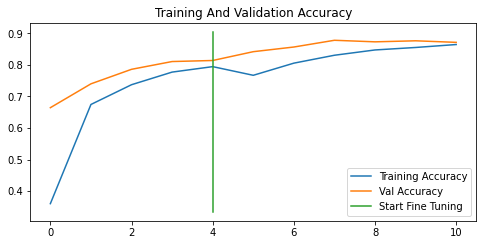

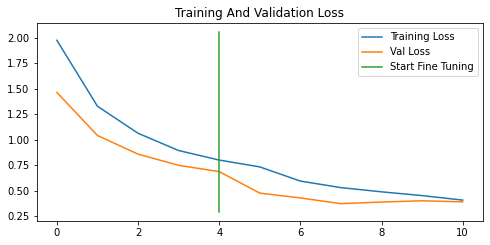

In [92]:
# How did fine-tuning go with more data ?
compare_history(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)

## Viewing our experiment data on TensorBoard
> **Note** : Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [94]:
# View tensorboard logs of transfer learning modelling experiments(should be ~4 models)
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes"\
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning."\
  --one_shot # exits the uploader once its finished uploading

2021-07-18 04:51:19.722424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3

In [ ]:
My TensorBoard experiments are available at : https://tensorboard.dev/experiment/4T8luPSLTO6qMGVCk7s2jQ/